# Algorithms (Default Parameters) with Cross-Validation

Prepared by [Ali Rifat Kaya](https://www.linkedin.com/in/alirifatkaya/)

# Table of Contents

1. [Import Libraries & Data](#Import-Libraries-&-Data)


2. [Vectorize Text Data](#Vectorize-Text-Data)


3. [Predict Helpful Reviews with Text Data](#Predict-Helpful-Reviews-with-Text-Data)


4. [Predict Review Rating with Text Data](#Predict-Review-Rating-with-Text-Data)


5. [Support Text Data with Extracted Features](#Support-Text-Data-with-Extracted-Features)


6. [Predict with Extracted Features](#Predict-with-Extracted-Features)


7. [Algorithm Spot Check](#Algorithm-Spot-Check)

    7.1. [Cross-Validation-Results](#Cross-Validation-Results)
    
    7.2. [Precision-Recall and ROC Plots](#Precision-Recall-and-ROC-Plots)


8. [Training Testing the Algorithms](#Training-Testing-the-Algorithms)

    8.1. [Training the Algorithms](#Training-the-Algorithms)
    
    8.2. [Testing the Algorithms](#Testing-the-Algorithms)
    
    8.3. [Confusion Matrices](#Confusion-Matrices)
    
    
9. [Conclusion](#Conclusion)

# Import Libraries & Read Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sparse
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

from imblearn.metrics import specificity_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, make_scorer

from IPython.core.display import display, HTML
from joblib import Parallel, delayed
from my_module import *
display(HTML('<style>.container { width:90% !important; }</style>'))
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('yelp_review_processed.csv')
with pd.option_context('display.max_colwidth', 20):
    display(df.head())

,review_clean,review_stars,set_word,number_of_photos,number_of_price,number_of_time,number_of_emots,average_useful_vote,review_age_days,review_useful
0,river yelp place...,5.0,159,0,0,0,0,2.375,2157,6
1,give restaur sta...,3.0,133,0,0,1,5,0.000,2331,0
2,boy love veggi r...,4.0,103,0,0,0,2,0.000,1245,0
3,vegan meal famil...,5.0,33,0,0,0,0,0.000,1417,0
4,visit veggi hous...,5.0,72,0,0,0,1,0.000,1853,0


# Vectorize Text Data

In [3]:
# only use text and extracted qualitative features
X = df.drop('review_useful', axis=1)
# all reviews which have 5 or greater helpful votes are labeled as helpful
# all other reviews are in the not helpful category
y = np.where(df.review_useful > 4, 1, 0)

In [4]:
# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, test_size=0.2, random_state=1)
print("""
        Number of helpful reviews in the training data: {:,}
        Number of helpful reviews in the test data: {:,}
        
        Distribution of the positive class in the training data: {:.2f}%
        Distribution of the positive class in the test data: {:.2f}%
        
        The class distributions are pretty close both in the training and the
        test data which will ensure the stability of the algorithms.
      """
      .format(y_train.sum(), y_test.sum(),
              (y_train[y_train == 1].size / y_train.size) * 100, 
              (y_test[y_test == 1].size / y_test.size) * 100))


        Number of helpful reviews in the training data: 29,433
        Number of helpful reviews in the test data: 7,513
        
        Distribution of the positive class in the training data: 5.02%
        Distribution of the positive class in the test data: 5.13%
        
        The class distributions are pretty close both in the training and the
        test data which will ensure the stability of the algorithms.
      


In [5]:
vectorizer = TfidfVectorizer(min_df=0.03, max_df=0.9, ngram_range=(1, 3))
vectorizer.fit(X_train.review_clean)
# training set
vector_train = vectorizer.transform(X_train.review_clean)
extracted_features_train = X_train.drop('review_clean', axis=1).values
# test set
vector_test = vectorizer.transform(X_test.review_clean)
extracted_features_test = X_test.drop('review_clean', axis=1).values

# Predict Helpful Reviews with Text Data

In [6]:
# use MultinomialNB algorithm to spot check how well the data is doing
nb = MultinomialNB()
nb.fit(vector_train, y_train)
predictions_nb = nb.predict(vector_test)

In [7]:
dt = DecisionTreeClassifier()
dt.fit(vector_train, y_train)
predictions_dt = dt.predict(vector_test)

# Predict Review Rating with Text Data

In [8]:
# change the target variable to review ratings (stars)
# all reviews which have 4 or above stars will be good reviews
# all other will be bad reviews
# we will try to predict if a review is a good one based on the review corpus
y_rating = np.where(df.review_stars >= 4, 1, 0)
# split into train and test set
# since the random state is the same each observation will exactly match the
# corresponding review rating in the target variable
X_train, X_test, y_train_rating, y_test_rating = train_test_split(
    X, y_rating, test_size=0.2, random_state=1)
# we will use the same training and test vectors

In [9]:
nb = MultinomialNB()
nb.fit(vector_train, y_train_rating)
predictions_rating_nb = nb.predict(vector_test)

In [10]:
dt = DecisionTreeClassifier()
dt.fit(vector_train, y_train_rating)
predictions_rating_dt = dt.predict(vector_test)

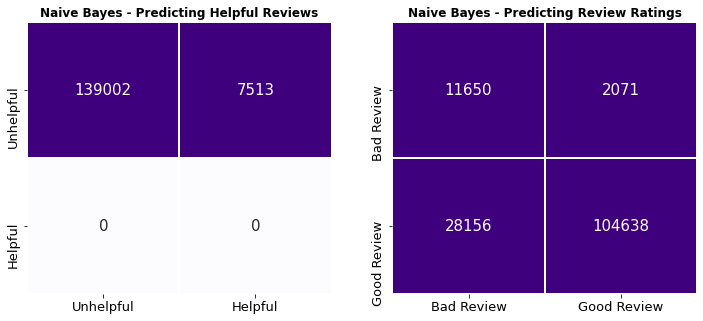

In [11]:
# check confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()
for ax, prediction, true_values, title, tick_labels in zip(
        axes,
        [predictions_nb, predictions_rating_nb],
        [y_test, y_test_rating],
        ['Naive Bayes - Predicting Helpful Reviews',
         'Naive Bayes - Predicting Review Ratings'],
        [['Unhelpful', 'Helpful'], ['Bad Review','Good Review']]):
    plot_confusion_matrix(y=true_values, predictions=prediction,
                          title=title, ticklabels=tick_labels, ax=ax, cmap='Purples', cbar=False)

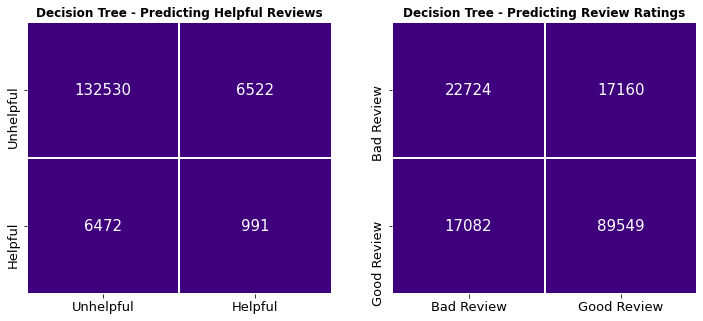

In [12]:
# check confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()
for ax, prediction, true_values, title, tick_labels in zip(
        axes,
        [predictions_dt, predictions_rating_dt],
        [y_test, y_test_rating],
        ['Decision Tree - Predicting Helpful Reviews',
         'Decision Tree - Predicting Review Ratings'],
        [['Unhelpful', 'Helpful'], ['Bad Review','Good Review']]):
    plot_confusion_matrix(y=true_values, predictions=prediction,
                          title=title, ticklabels=tick_labels, ax=ax, cmap='Purples', cbar=False)

        As seen from the confusion matrices, the text data is suitable
        for predicting the review rating. Multinomial Naive Bayes and Decision
        Tree outperform in predicting the ratings. However, we cannot say the
        same for predicting the helpful reviews based on only text data.
        For this reason, we will employ some features such as the number of 
        photos, the number of price information etc. that are extracted from 
        the text. Hopefully, they can increase the model performance.

# Support Text Data with Extracted Features

In [19]:
x_train = sparse.hstack([vector_train, extracted_features_train]).A
x_test = sparse.hstack([vector_test, extracted_features_test]).A

In [20]:
nb = MultinomialNB()
nb.fit(x_train, y_train)
predictions_nb = nb.predict(x_test)

In [21]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
predictions_dt = dt.predict(x_test)

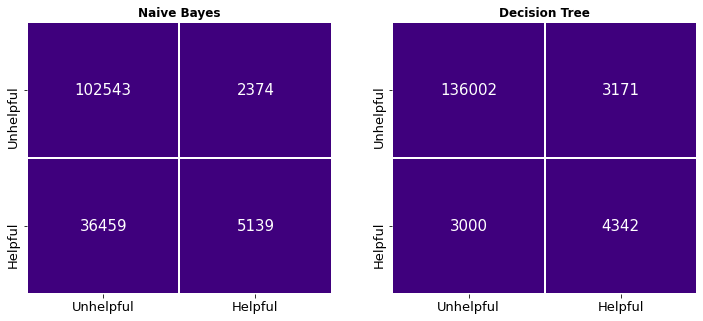

In [22]:
# check confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()
for ax, predictions, title in zip(axes, [predictions_nb, predictions_dt],
                                 ['Naive Bayes', 'Decision Tree']):
    plot_confusion_matrix(y=y_test,
                          predictions=predictions,
                          title=title,
                          ticklabels=['Unhelpful', 'Helpful'],
                          ax=ax,
                          cmap='Purples',
                          cbar=False)

# Predict with Extracted Features

In [23]:
nb = MultinomialNB()
nb.fit(extracted_features_train, y_train)
predictions_nb = nb.predict(extracted_features_test)

In [24]:
dt = DecisionTreeClassifier()
dt.fit(extracted_features_train, y_train)
predictions_dt = dt.predict(extracted_features_test)

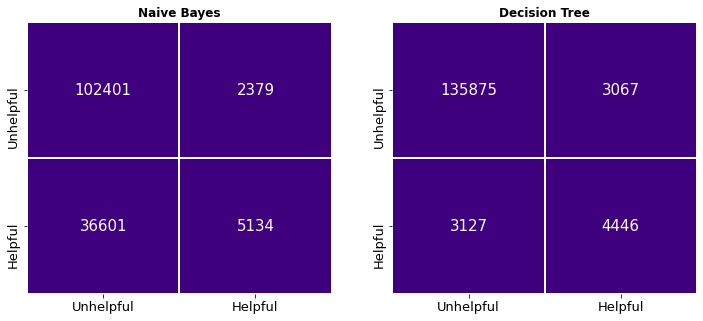

In [25]:
# check confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()
for ax, predictions, title in zip(axes, [predictions_nb, predictions_dt],
                                 ['Naive Bayes', 'Decision Tree']):
    plot_confusion_matrix(y=y_test,
                          predictions=predictions,
                          title=title,
                          ticklabels=['Unhelpful', 'Helpful'],
                          ax=ax,
                          cmap='Purples',
                          cbar=False)

        So far, Naive Bayes and Decision Tree algorithms are trained and tested with 
        three different training and test sets.
        First, both algorithms are trained using only Tf-Idf Vector which is purely
        based on review corpus.
        Second, both algorithms are trained combination of Tf-Idf Vector and features
        that are extracted from the review corpus.
        Finally, both algorithms are trained using only the extracted features.
        
        On the other hand, Naive Bayes and Decision Tree algorithms are employed in
        order to predict a review rating star based on the review corpus. Surprisingly,
        they both outperform their performances on predicting helpful reviews.
        
        As a result, we can say that the review corpus is a suitable source for predicting
        review rating but not for predicting helpful reviews. In other words, helpful
        reviews are not identified based on the vocabulary used in the corpus but the
        information they contain. For this reason, we will focus on the extracted features
        such as the number of price information, the number of photos etc.

# Algorithm Spot Check

In [6]:
# define objects - lm algorithms
lr = LogisticRegression()
nb = MultinomialNB()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
xgb = XGBClassifier()

# (model_name, model, scaling)
estimators = [('Logistic Regression', lr), ('Naive Bayes', nb),
              ('KNN Classifier', knn), ('Decision Tree Classifier', dt),
              ('Random Forest Classifier', rf), ('Extra Trees Classifier', et),
              ('XGBoost Classifier', xgb)]

scalers = [True, False, True, False, False, False, False]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# cross-validation
cv_results = do_cross_validation(X=extracted_features_train,
                                 y=y_train,
                                 estimators=estimators,
                                 cv=cv,
                                 scalers=scalers,
                                 verbose=False)

## Cross-Validation Results

In [8]:
import pickle
# results as a pickle file
pickle.dump(cv_results, open('cv_results.pickle', 'wb'))
# calculates mean and standard deviation for cross validation scores
mean_scores, std_devs = calculate_statistics(cv_results)
# puts the mean scores in a dataframe
df_mean = make_df_statistics(mean_scores)
# puts the standard deviations in a dataframe
df_std = make_df_statistics(std_devs)
df_stats = df_mean.merge(df_std, left_index=True, right_index=True, suffixes=(
    '_mean', '_std'))  # merge mean and standard deviations dataframes
df_stats

,matthews_corrcoef_mean,roc_auc_score_mean,pr_auc_score_mean,matthews_corrcoef_std,roc_auc_score_std,pr_auc_score_std
Logistic Regression,0.620760,0.974574,0.722572,0.009843,0.000630,0.002439
Naive Bayes,0.205605,0.760311,0.341370,0.003242,0.004343,0.005669
KNN Classifier,0.616450,0.897222,0.676677,0.006632,0.003973,0.003578
Decision Tree Classifier,0.570956,0.789274,0.602904,0.004538,0.003101,0.004172
Random Forest Classifier,0.667442,0.969329,0.754909,0.004467,0.001145,0.003417
Extra Trees Classifier,0.639498,0.965461,0.727428,0.004460,0.001451,0.003796
XGBoost Classifier,0.681200,0.980492,0.781813,0.002178,0.000400,0.002689


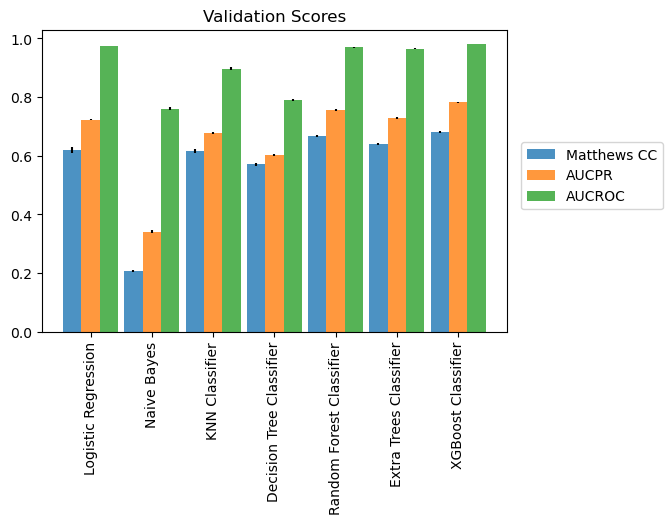

In [9]:
fig, ax = plt.subplots()  # generates figure and axes object
fig.set_dpi(100)  # set the resolution of the plot
width = 0.3  # set bar width
idx = np.arange(
    df_stats.shape[0])  # number of ticks for x-axis and bar location
ax.bar(idx, df_stats.matthews_corrcoef_mean, width,
       yerr=df_stats.matthews_corrcoef_std, align='center',
       alpha=0.8, ecolor='black')  # plots matthews correlation coef.
ax.bar(idx + width, df_stats.pr_auc_score_mean, width,
       yerr=df_stats.pr_auc_score_std, align='center',
       alpha=0.8, ecolor='black')  # plots AUCPR
ax.bar(idx + 2*width, df_stats.roc_auc_score_mean, width,
       yerr=df_stats.roc_auc_score_std, align='center',
       alpha=0.8, ecolor='black')  # plots AUCROC
ax.set_xticks(idx + 0.3)  # adjust the position of xticks
ax.set_xticklabels(df_stats.index, rotation=90)  # changes the tick labels
ax.legend(['Matthews CC', 'AUCPR', 'AUCROC'],
          bbox_to_anchor=(1.35, 0.65))  # set the legend
ax.set_title('Validation Scores')
plt.show()  # shows the plot

        The algorithms have pretty consistent cross-validation scores for each metric.
        Even though the scores changes for each metric such as AUCROC score is the 
        highest score and Matthews CC is the lowest score for each algorithm, the
        pattern is consistent. In other words, even the metric scores changes the
        pattern among the metrics stays consistent.
        
        In our case, AUCPR score may be more informative than AUCROC score. However,
        in the overall perspective, there are small differences among the algorithms.
        As we will see below, in the confusion matrices, XGBoost is the best algorithm
        yet for detecting helpful reviews.
        
        Our final idea is to recommend reviews from the most helpful to the least helpful.
        This kind of an approach requires a finer process than just categorizing the
        reviews if they are helpful. For this reason, we will calculate the predicted
        probabilities for each review and arrange them in descending order. The review which
        has the highest probability for the helpful class will be recommended as top helpful
        review.

## Precision-Recall and ROC Plots

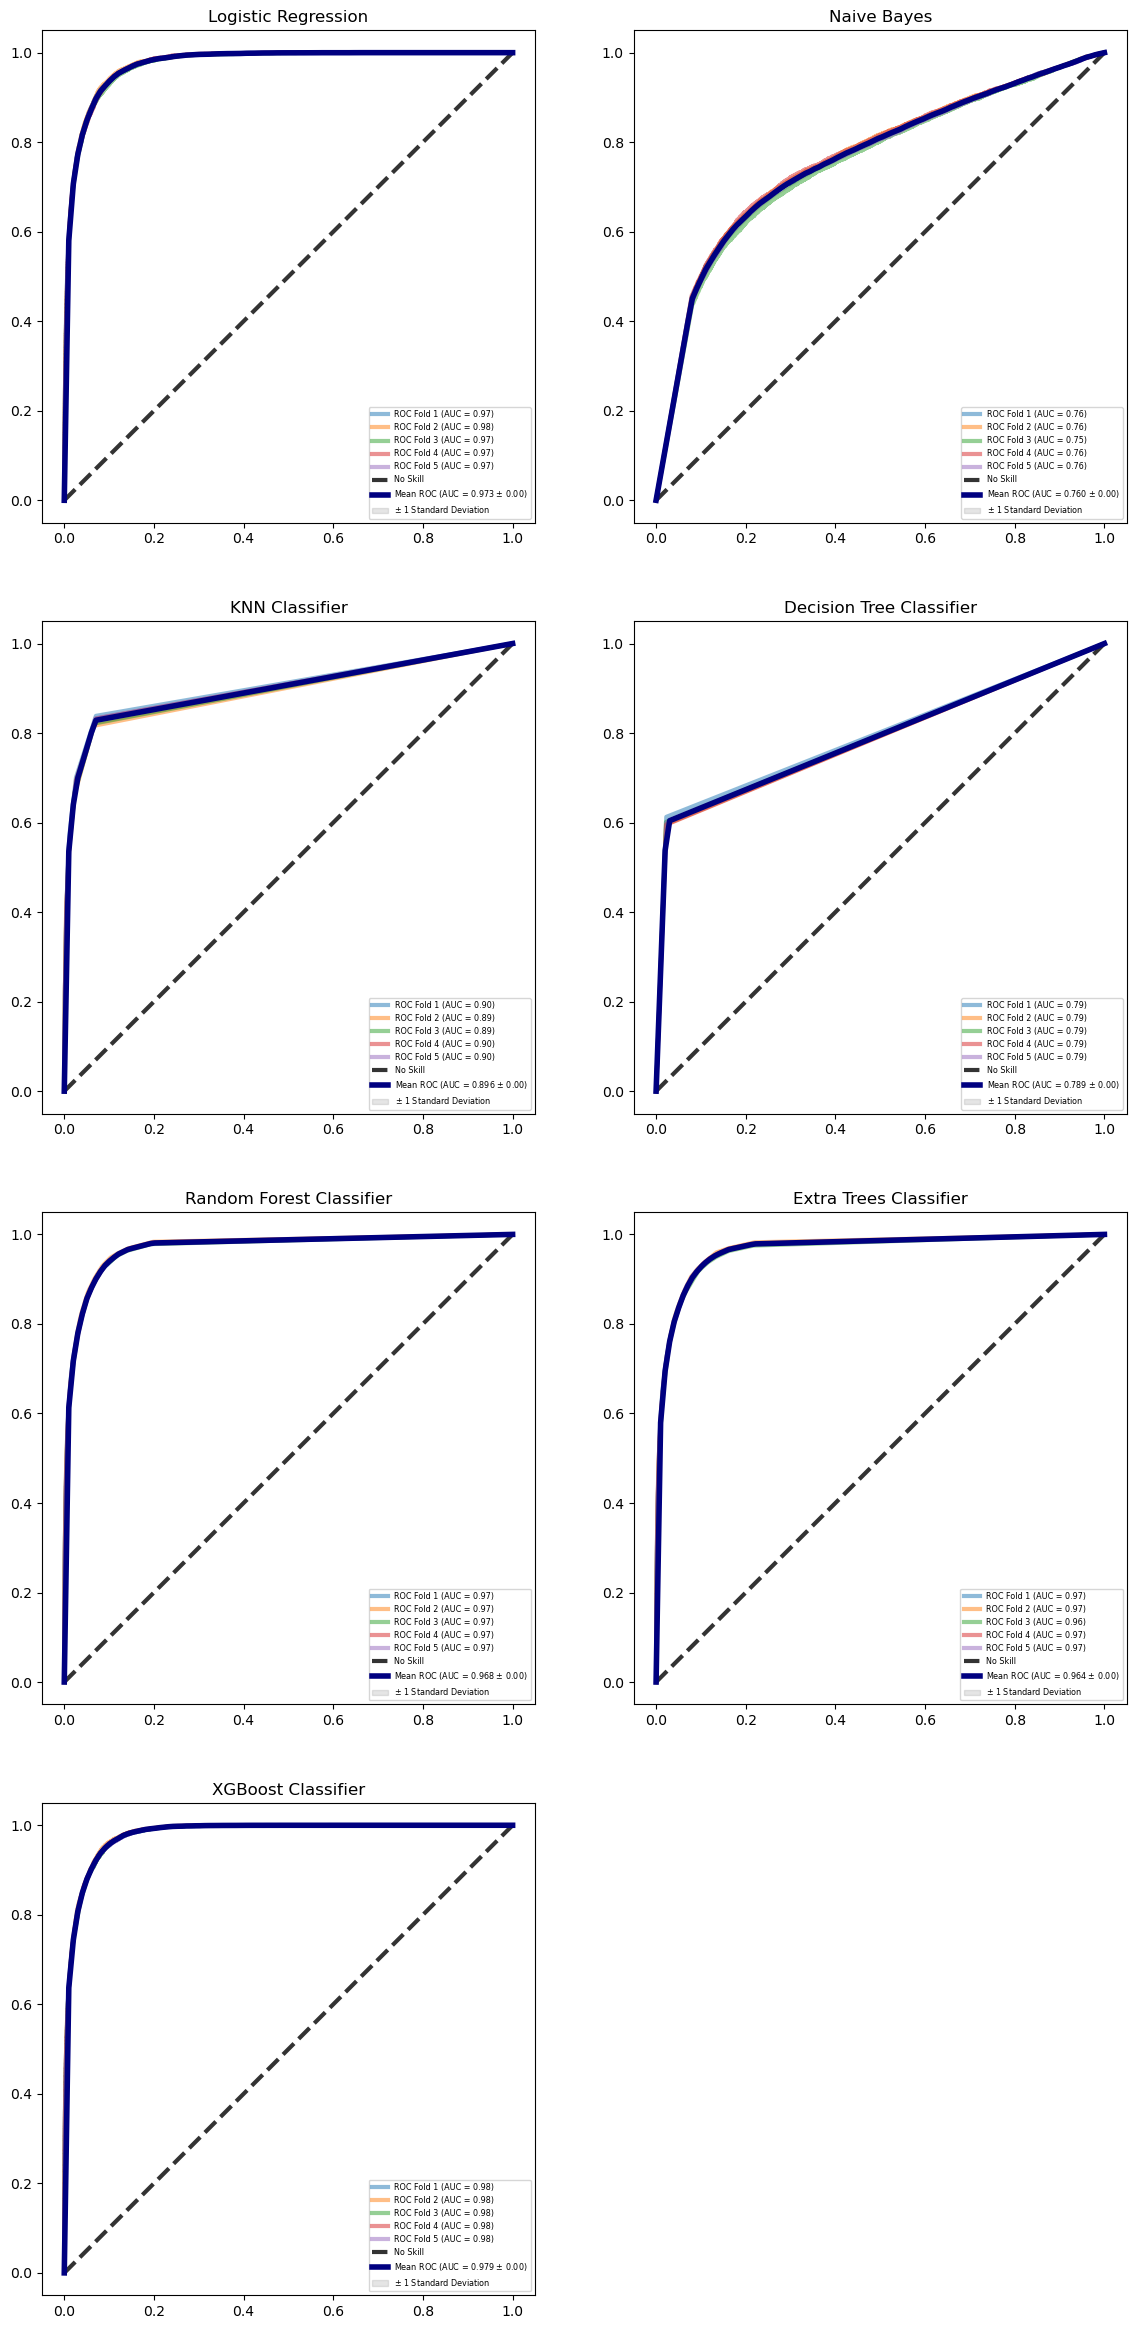

In [11]:
# plot for roc curves - 10 subplots
fig, axes = plt.subplots(4, 2, figsize=(14, 30))
fig.set_dpi(100)  # set the resolution of the plot
axes = axes.ravel()  # flattens the axes list
# plots roc curves
for idx, (model, results) in enumerate(cv_results.items()):
    plot_roc_curve(results['fprs'],
                   results['tprs'], title=model, ax=axes[idx])
fig.delaxes(axes[-1])
plt.show()

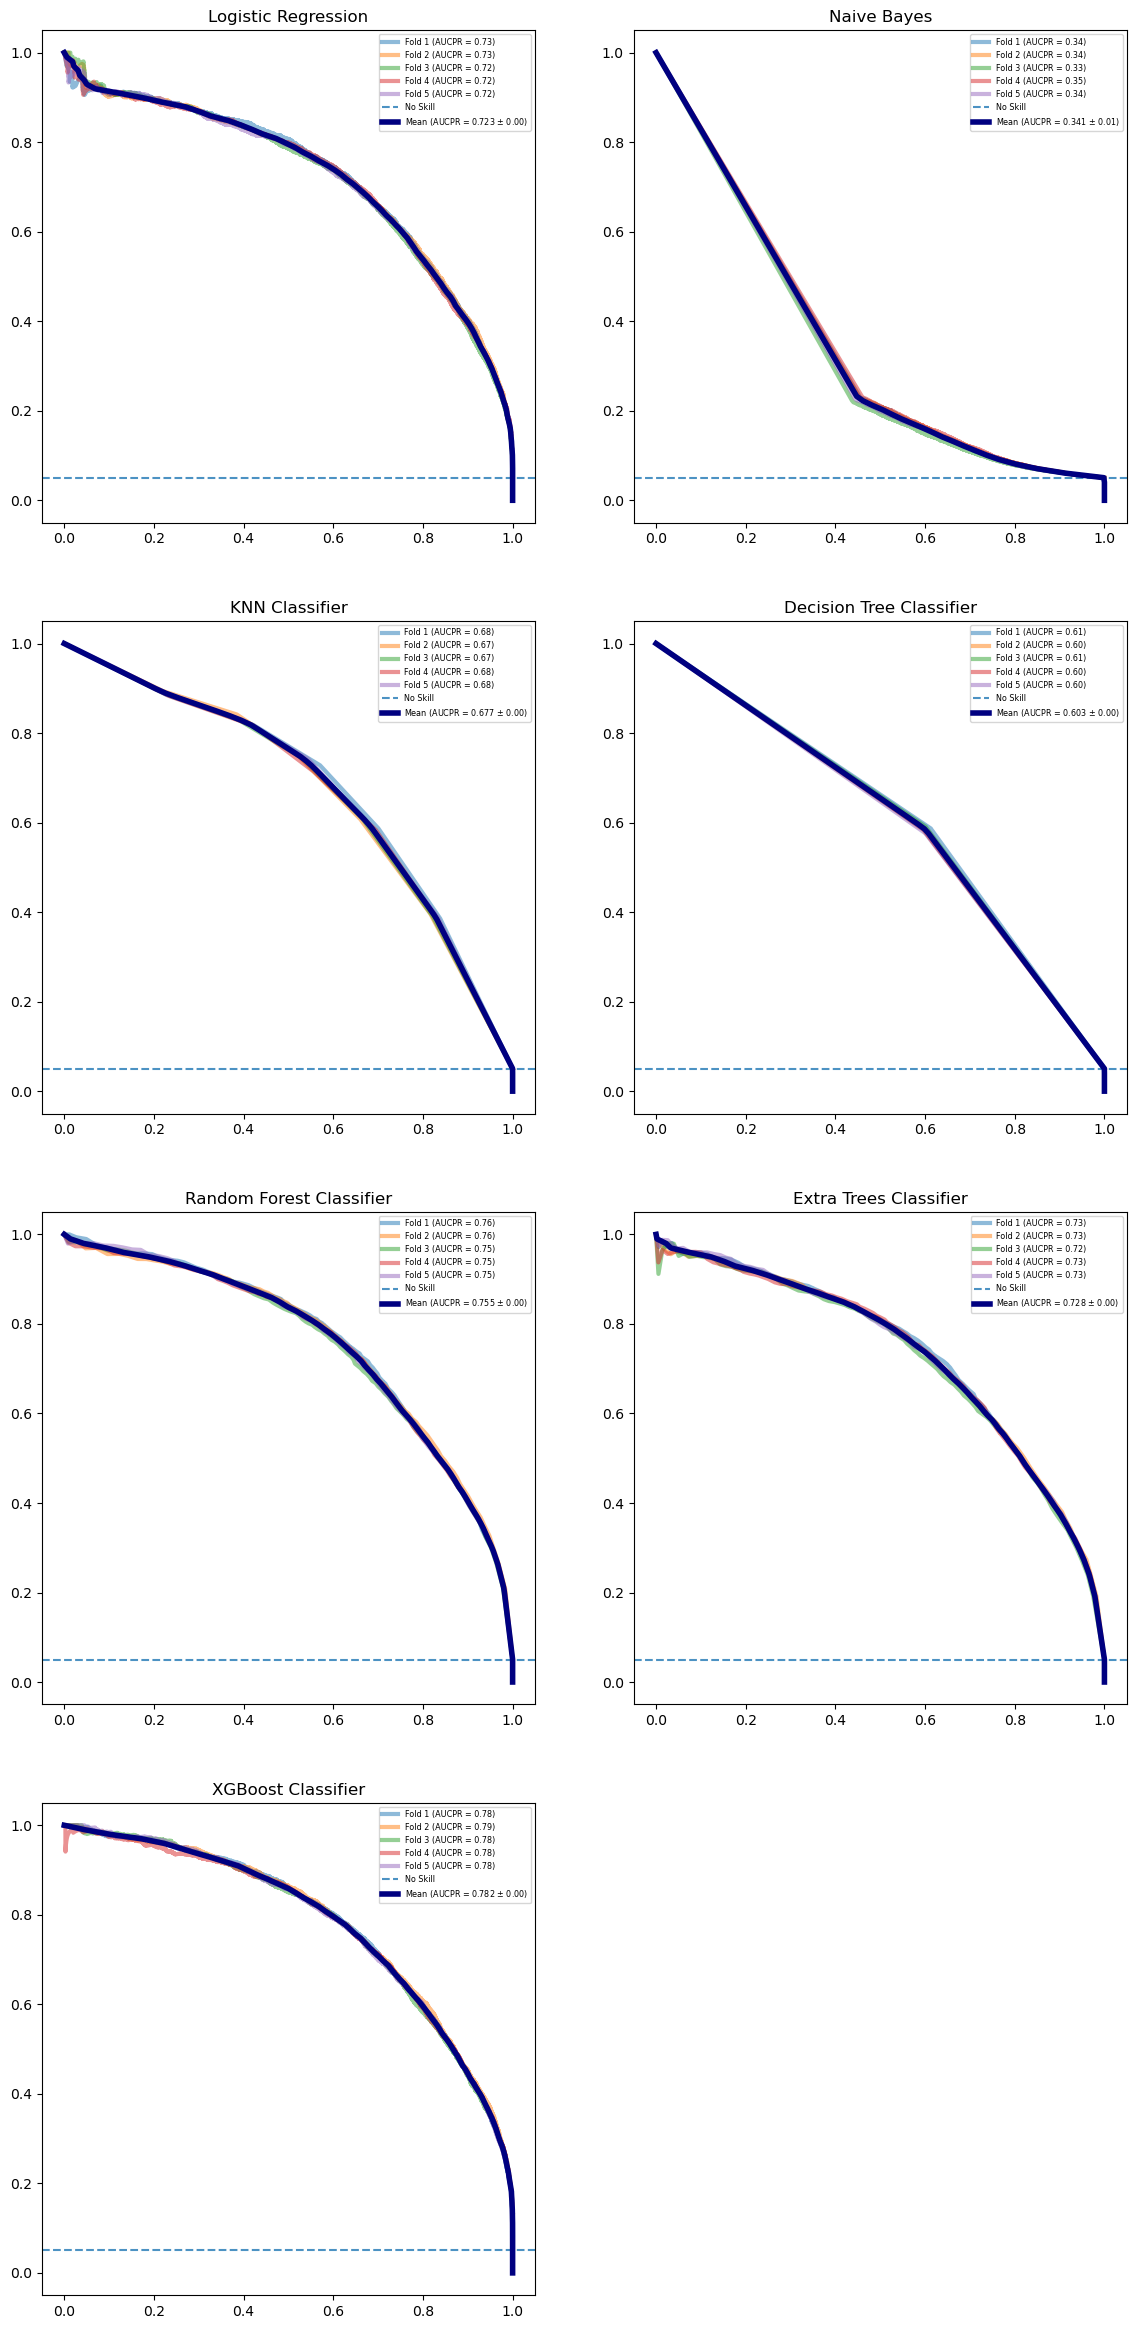

In [12]:
fig, axes = plt.subplots(4, 2, figsize=(14, 30))
fig.set_dpi(100)
axes = axes.ravel()
for idx, (model, results) in enumerate(cv_results.items()):
    plot_precision_recall_curve(y_train, results['precisions'],
                                results['recalls'], title=model, ax=axes[idx])
fig.delaxes(axes[-1])
plt.show()

# Training-Testing the Algorithms

## Training Algorithms

In [13]:
# define objects - lm algorithms
lr = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
xgb = XGBClassifier()
# (model_name, model, scaling)
estimators = [('Logistic Regression', lr),
              ('KNN Classifier', knn),
              ('Decision Tree Classifier', dt),
              ('Random Forest Classifier', rf),
              ('Extra Trees Classifier', et),
              ('XGBoost Classifier', xgb)]
scalers = [True, True, False, False, False, False]
# train models
training_scores = train_model(
    estimators=estimators, X=extracted_features_train, y=y_train, scalers=scalers)
training_scores_, _ = calculate_statistics(training_scores)
df_training = make_df_statistics(training_scores_)
df_training

,matthews_corrcoef,roc_auc_score,pr_auc_score
Logistic Regression,0.621264,0.974602,0.722705
KNN Classifier,0.707501,0.989072,0.846773
Decision Tree Classifier,0.999893,1.000000,1.000000
Random Forest Classifier,0.999785,1.000000,1.000000
Extra Trees Classifier,0.999893,1.000000,1.000000
XGBoost Classifier,0.704116,0.983855,0.815934


        Based on the cross-validation scores we only eliminated Naive Bayes algorithm
        but kept all the remaining algorithms for the final stage.

## Testing Algorithms

In [14]:
test_scores = test_model(estimators=estimators,
                         X=extracted_features_test, y=y_test, scalers=scalers)
test_scores_, _ = calculate_statistics(test_scores)
df_test = make_df_statistics(test_scores_)
df_test

,matthews_corrcoef,roc_auc_score,pr_auc_score
Logistic Regression,0.579448,0.972695,0.721879
KNN Classifier,0.581273,0.874482,0.652075
Decision Tree Classifier,0.567274,0.784946,0.600041
Random Forest Classifier,0.670365,0.968366,0.759109
Extra Trees Classifier,0.644009,0.965266,0.733773
XGBoost Classifier,0.684150,0.980748,0.789648


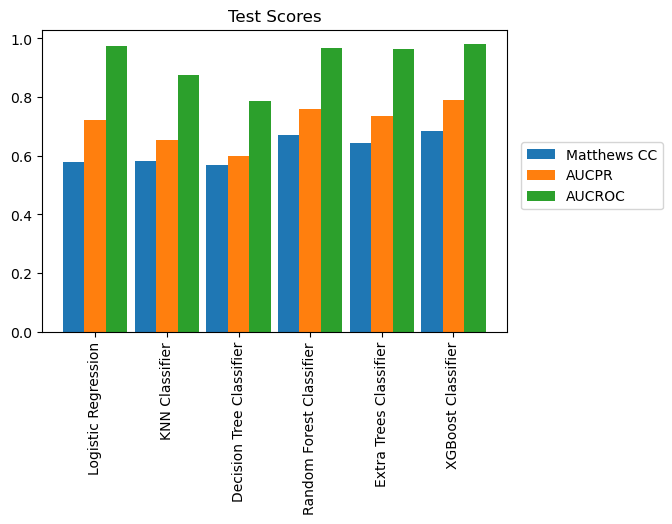

In [15]:
fig, ax = plt.subplots()  # generates figure and axes object
fig.set_dpi(100)  # set the resolution of the plot
width = 0.3  # set bar width
idx = np.arange(
    df_test.shape[0])  # number of ticks for x-axis and bar location
# plots matthews correlation coef.
ax.bar(idx, df_test.matthews_corrcoef, width)
ax.bar(idx + width, df_test.pr_auc_score, width)  # plots AUCPR
ax.bar(idx + 2 * width, df_test.roc_auc_score, width)  # plots AUCROC
ax.set_xticks(idx + 0.3)  # adjust the position of xticks
ax.set_xticklabels(df_test.index, rotation=90)  # changes the tick labels
ax.legend(['Matthews CC', 'AUCPR', 'AUCROC'],
          bbox_to_anchor=(1.35, 0.65))  # set the legend
ax.set_title('Test Scores')
plt.show()  # shows the plot

## Confusion Matrices

In [ ]:
for ax, predictions, title in zip(axes, [predictions_nb, predictions_dt],
                                 ['Naive Bayes', 'Decision Tree']):
    plot_confusion_matrix(y=y_test,
                          predictions=predictions,
                          title=title,
                          ticklabels=['Unhelpful', 'Helpful'],
                          ax=ax,
                          cmap='Purples',
                          cbar=False)

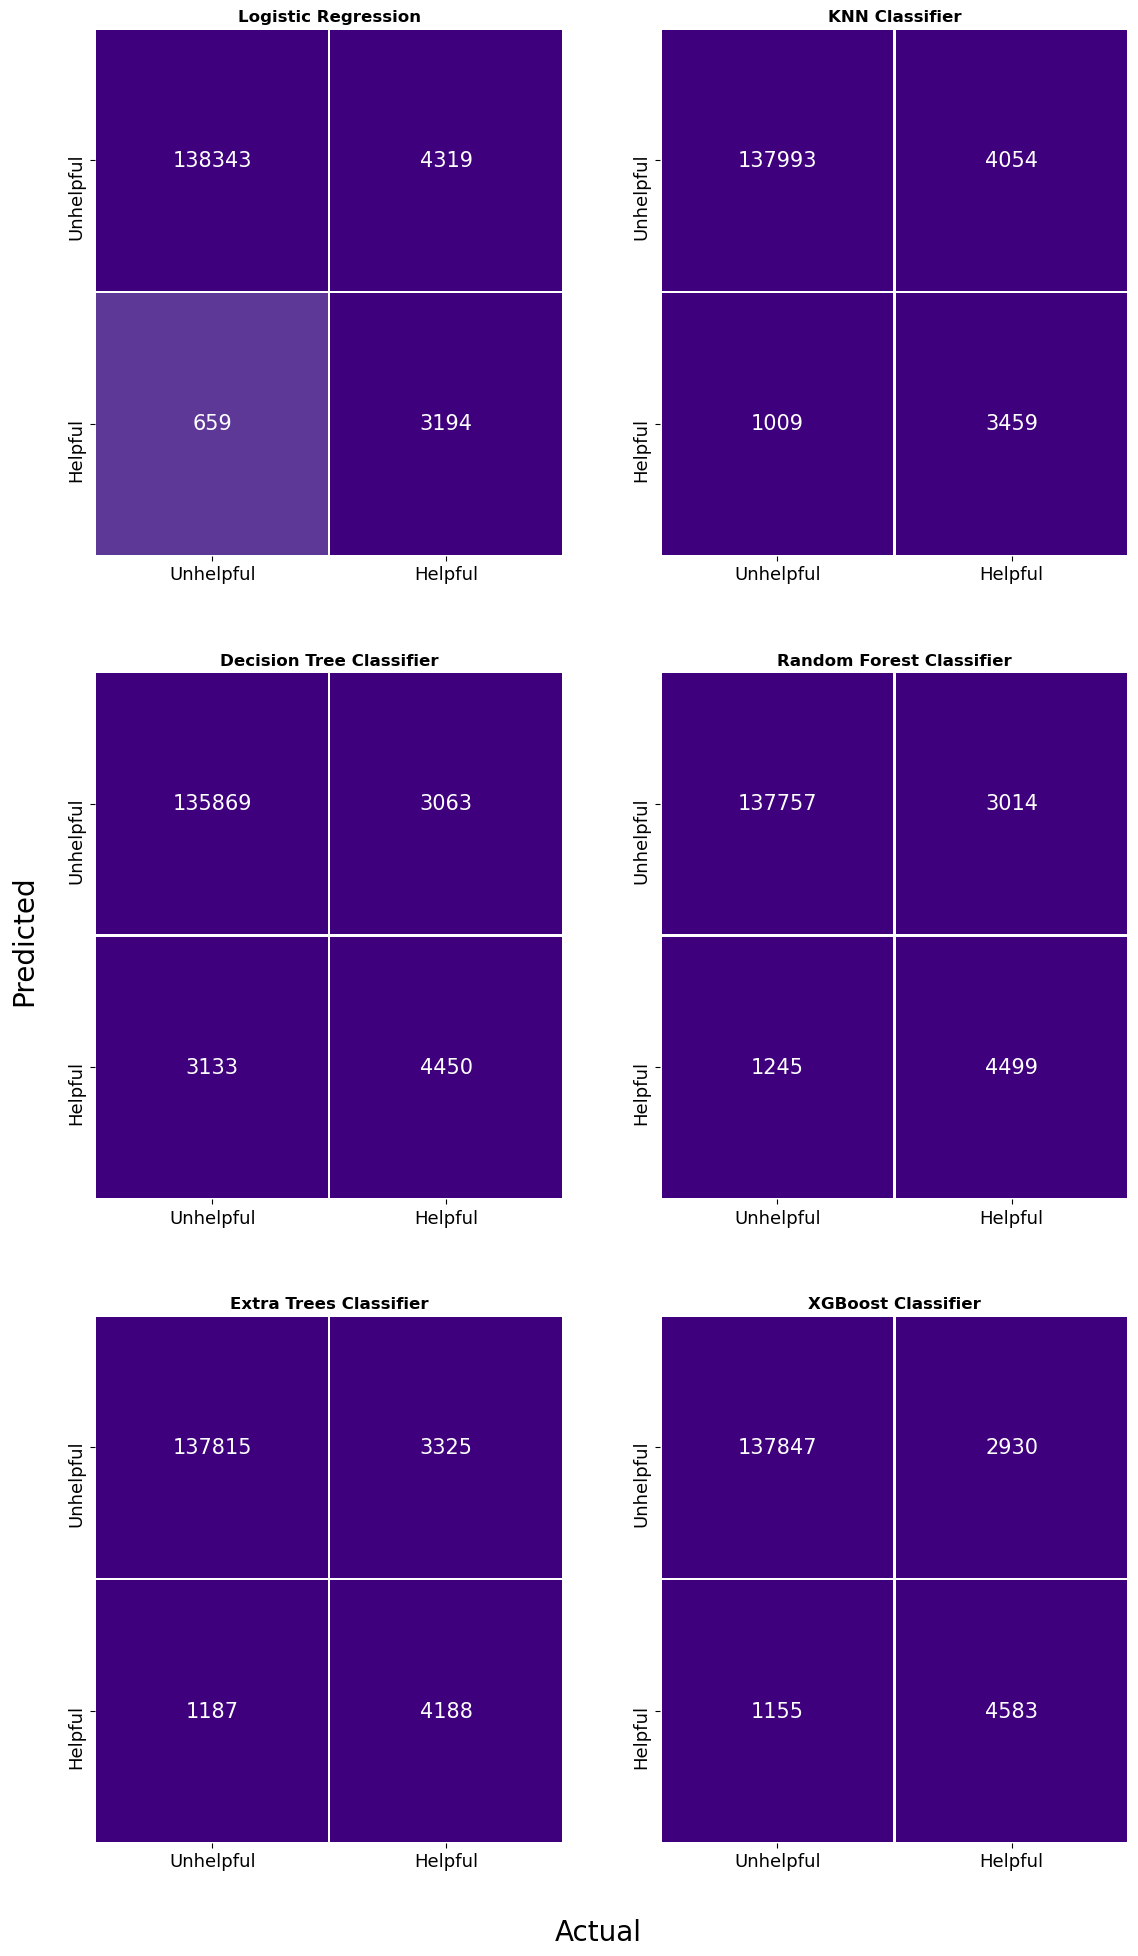

In [18]:
predicted_values_all = []
for model in df_test.index:
    predicted_values_all.append(test_scores[model]['predictions'][0])

fig, axes = plt.subplots(3, 2, figsize=(12, 20))
fig.set_dpi(100)
axes = axes.ravel()

for idx, model in enumerate(df_test.index):
    plot_confusion_matrix(y=y_test,
                          predictions=predicted_values_all[idx],
                          title=model,
                          ticklabels=['Unhelpful', 'Helpful'],
                          ax=axes[idx],
                          cmap='Purples',
                          cbar=False)
fig.text(0.5, 0, 'Actual', ha='center', size=20)
fig.text(0.01, 0.5, 'Predicted', va='center', size=20, rotation='vertical')
plt.tight_layout(5)
plt.show()

        Based on the test scores and the confusion matrices, we can say
        that the best algorithm for detecting helpful reviews is XGBoost.
        
        Top three algorithms are presented in order:
        (Based on FN (False Negative) and FP (False Positive) - lesser is better - numbers)
        
        1. XGBoost Classifier
        2. Random Forest Classifier
        3. Extra Trees Classifier
        